<a href="https://colab.research.google.com/github/viniciusguirra/Projetos_Soulcode/blob/main/Projeto_Final_AD2_Grupo7_Transito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto Final**

**Escola**: SoulCode Academy

**Curso**: Bootcamp Analista de Dados - Martech - AD2

**Período**: Semana 12 - Agosto/2023

**Tema**: Trânsito

**Professores**: Franciane Rodrigues, Douglas Ribeiro e Jonathas Carneiro

**Grupo 7** - **Autores**:
- Jéssica Caroline
- Marcela Silva
- Marcella Macedo
- Maria Eduarda
- Priscilla Ligotte
- Vinicius Guirra


## **Dados**

**Período das bases**: 2010 a 2022

Os 5 datasets que utilizamos nesta análise foram extraídos da MobiliDADOS, uma plataforma "criada com o objetivo de promover o uso de informações confiáveis nos processos de elaboração, monitoramento e avaliação de políticas de mobilidade e desenvolvimento urbano."

1.   Comprometimento de Renda - 2018 a 2022
2.   Tempo de Deslocamento - Censo 2010
3.   População - Capitais - 2018 a 2022
4.   Dados Brutos = Capitais - pessoas próximas da rede de transporte de média e alta capacidade (trens, metrôs, VLTs, BRTs e barcas) - por renda, raça e gênero - 2018 a 2021
5.   Taxa de Motorização - 2017 a 2022

**Fonte**: https://mobilidados.org.br/database?category_slug=dados-brutos-e-indicadores
**Período Analisado**: 2018 a 2022

**População próxima da rede de transporte de média e alta capacidade:**

* SM - Salário Mínimo

1. Geral - Percentual da população total
2. Domicílios_0_1/2_próximos_estação_TMA - renda per capita entre 0 e 1/2 SM
3. Domicílios_1/2_1_próximos_estação_TMA - renda per capita entre 1/2 e 1 SM
4. Domicílios_1_3_próximos_estação_TMA - renda per capita entre 1 e 3 SM
5. Domicílios_3_mais_próximos_estação_TMA - renda per capita acima de 3 SM
6. Mulheres_negras - Percentual da população de mulheres negras
7. Mulheres_menos_1_salário_mínimo_próximas_estação_TMA - mulheres com renda abaixo de 1 SM

## **Problema de negócio**

**5W**

* Quais são os hábitos de deslocamento da população?
* Qual é o impacto da falta de infraestrutura de transportes nas cidades?
* Quem pode se beneficiar dessa análise?
* O que chama mais atenção: Tempo de deslocamento, gasto com transportes, emissão de CO2 com o aumento das frotas.
* Quais projetos poderiam beneficiar a mobilidade urbana?


**Análise de Tarifas**: relação entre as tarifas de transporte e comprometimento de renda

**Análise Geográfica**: tempo de deslocamento nos grandes centros e distância de habitantes das redes de transporte

**Análise do Impacto das Emissões de CO2**: como o aumento das frotas de automóveis contribuem para maior poluição do ambiente e aumento do tempo de deslocamento.

## Instalações e Importações
Bibliotecas necessárias para o processo de ETL.

In [ ]:
# Acessar GCP
!pip install gcsfs

# Biblioteca de validação de dados
!pip install pandera

# Acessar MongoDB
!pip install pymongo

In [ ]:
# Bibliotecas de sistema operacional, análise de dados, arrays e funções, validação de dados, dataviz com Matplotlitb e outros gráficos complexos:
import os
import pandas as pd
import numpy as np
import pandera as pa
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from pymongo import MongoClient

# Pegar o arquivo pelo bucket do GCP
from  google.cloud import storage

In [ ]:
# PySPARK - instalando os requisitos necessários
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
# Importando as ferramentas e criando o ambiente virtual para o spark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
# Criando a sessão clusterizada do PySpark
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
from pyspark.sql.functions import regexp_replace
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Para deixar a visualição das tabelas mais amigável
spark

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# ETL
Extração, transformação, carregamento e possível automação do processo de etl dos dados.


# **Extração**

In [ ]:
# Acesso a GCP pela Chave de Conta de Serviço
serviceAccount = '/content/projeto-final-394613-a0727b1754a2.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount

### DF1 - Comprometimento

In [ ]:
# Acesso ao arquivo da GCP
client = storage.Client()
bucket = client.get_bucket('insighttrafic')
bucket.blob('comprometimento.csv')
path1 = 'gs://insighttrafic/dados_brutos/comprometimento.csv'

In [ ]:
# Abertura da base de dados e cópia de segurança (bucket)
df1 = pd.read_csv(path1,sep=',')
df1back = df1.copy()

In [ ]:
# Visualização de seção aleatória do dataframe
df1.sample(5)

,sigla_uf,id_municipio,ano,tarifas,comprometimento_salario_minimo,comprometimento_renda_domesticas_negras
325,AC,1200401,2017,3.0,0.165422,NaN
86,MS,5002704,2008,2.1,0.204819,0.189873
294,MT,5103403,2010,2.3,0.264706,NaN
98,RS,4314902,2008,2.0,0.240964,0.175439
84,RR,1400100,2008,1.8,0.216867,0.203390


###DF2 - Deslocamento

In [ ]:
# Acesso ao arquivo da GCP
client = storage.Client()
bucket = client.get_bucket('insighttrafic')
bucket.blob('deslocamentos.xlsx')
path2 = 'gs://insighttrafic/dados_brutos/deslocamentos.xlsx'

In [ ]:
# Abertura da base de dados e cópia de segurança (bucket)
df2=pd.read_excel(path2)
df2back = df2.copy()

In [ ]:
# Visualização do dataframe
df2.head(6)

,Indice_busca,Cod,Município,Estado,Tempo habitual de deslocamento para o trabalho,Unnamed: 5,Tempo médio,% acima de 1 hora,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,5200050 - Até cinco minutos,5200050,Abadia de Goiás,GO,Até cinco minutos,482,-,-,NaN,NaN,NaN,NaN,NaN
1,5200050 - De seis minutos até meia hora,5200050,Abadia de Goiás,GO,De seis minutos até meia hora,942,-,-,NaN,NaN,NaN,NaN,NaN
2,5200050 - Mais de duas horas,5200050,Abadia de Goiás,GO,Mais de duas horas,46,-,-,NaN,NaN,NaN,NaN,NaN
3,5200050 - Mais de meia hora até uma hora,5200050,Abadia de Goiás,GO,Mais de meia hora até uma hora,726,-,-,NaN,NaN,NaN,NaN,NaN
4,5200050 - Mais de uma hora até duas horas,5200050,Abadia de Goiás,GO,Mais de uma hora até duas horas,420,-,-,NaN,NaN,NaN,NaN,NaN
5,5200050 - Total,5200050,Abadia de Goiás,GO,Total,2615,36,0.178203,NaN,NaN,NaN,NaN,NaN


###DF3 - População

In [ ]:
# Acesso ao arquivo da GCP
client = storage.Client()
bucket = client.get_bucket('insighttrafic')
bucket.blob('populacao_capitais.csv')
path3 = 'gs://insighttrafic/dados_brutos/populacao_capitais.csv'

In [ ]:
## Abertura da base de dados e cópia de segurança (bucket)
df3=pd.read_csv(path3)
df3back = df3.copy()

In [ ]:
# Visualização do dataframe
df3.head(6)

,COD_UF,UF,CD_MUN6,CD_MUN7,MUNICIPIO,CAPITAL,REGIAO METROPOLITANA,Pop_2000,Pop_2001,Pop_2002,...,Pop_2013,Pop_2014,Pop_2015,Pop_2016,Pop_2017,Pop_2018,Pop_2019,Pop_2020,Pop_2021,Pop_2022
0,11,RO,1100205,110020,Porto Velho,Sim,Região Metropolitana de Porto Velho,334661,342264,347844,...,484992,494013,502748,511219,519436,519531,529544,539354,548952,460413
1,12,AC,1200401,120040,Rio Branco,Sim,-,253059,261430,267740,...,357194,363928,370550,377057,383443,401155,407319,413418,419452,364756
2,13,AM,1302603,130260,Manaus,Sim,Região Metropolitana de Manaus,1405835,1451958,1488805,...,1982177,2020301,2057711,2094391,2130264,2145444,2182763,2219580,2255903,2063547
3,14,RR,1400100,140010,Boa Vista,Sim,Região Metropolitana da Capital,200568,208514,214541,...,308996,314900,320714,326419,332020,375374,399213,419652,436591,413486
4,15,PA,1501402,150140,Belém,Sim,Região Metropolitana de Belém,1280614,1304314,1322683,...,1425922,1432844,1439561,1446042,1452275,1485732,1492745,1499641,1506420,1303389
5,16,AP,1600303,160030,Macapá,Sim,Região Metropolitana de Macapá,283308,295898,306583,...,437256,446757,456171,465495,474706,493634,503327,512902,522357,442933


In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   COD_UF                27 non-null     int64 
 1   UF                    27 non-null     object
 2   CD_MUN6               27 non-null     int64 
 3   CD_MUN7               27 non-null     int64 
 4   MUNICIPIO             27 non-null     object
 5   CAPITAL               27 non-null     object
 6   REGIAO METROPOLITANA  27 non-null     object
 7   Pop_2000              27 non-null     int64 
 8   Pop_2001              27 non-null     int64 
 9   Pop_2002              27 non-null     int64 
 10  Pop_2003              27 non-null     int64 
 11  Pop_2004              27 non-null     int64 
 12  Pop_2005              27 non-null     int64 
 13  Pop_2006              27 non-null     int64 
 14  Pop_2007              27 non-null     int64 
 15  Pop_2008              27 non-null     int6

In [ ]:
# Colunas do df
df3.columns

Index(['COD_UF', 'UF', 'CD_MUN6', 'CD_MUN7', 'MUNICIPIO', 'CAPITAL',
       'REGIAO METROPOLITANA', 'Pop_2000', 'Pop_2001', 'Pop_2002', 'Pop_2003',
       'Pop_2004', 'Pop_2005', 'Pop_2006', 'Pop_2007', 'Pop_2008', 'Pop_2009',
       'Pop_2010', 'Pop_2011', 'Pop_2012', 'Pop_2013', 'Pop_2014', 'Pop_2015',
       'Pop_2016', 'Pop_2017', 'Pop_2018', 'Pop_2019', 'Pop_2020', 'Pop_2021',
       'Pop_2022'],
      dtype='object')

###DF4 - Proximidade de Transportes

In [ ]:
# Acesso ao arquivo da GCP
client = storage.Client()
bucket = client.get_bucket('insighttrafic')
bucket.blob('proximidade_transporte.csv')
path4 = 'gs://insighttrafic/dados_brutos/proximidade_transporte.csv'

In [ ]:
# Abertura da base de dados e cópia de segurança (bucket)
df4=pd.read_csv(path4,delimiter=';')
df4back = df4.copy()

In [ ]:
# Visualização do dataframe
df4.head(6)

,UF,Cod,MUNICIPIO,ID,Categoria,ANO,proximo_transporte,pop_total
0,PA,1501402,BELÉM,1,População,2017,52411,1391636
1,PA,1501402,BELÉM,2,Domicílios_0_1/2,2017,2467,129521
2,PA,1501402,BELÉM,3,Domicílios_1/2_1,2017,3188,103778
3,PA,1501402,BELÉM,4,Domicílios_1_3,2017,5327,90673
4,PA,1501402,BELÉM,5,Domicílios_3_mais,2017,3752,45205
5,PA,1501402,BELÉM,6,Mulheres_negras,2017,17824,519057


## DF5 - Motorização

In [ ]:
# Acesso ao arquivo da GCP
client = storage.Client()
bucket = client.get_bucket('insighttrafic')
bucket.blob('motorizacao_bruto.xlsx')
path5 = 'gs://insighttrafic/dados_brutos/motorizacao_bruto.xlsx'

In [ ]:
# Abertura da base de dados e cópia de segurança (bucket)
df5=pd.read_excel(path5)
df5back = df5.copy()

In [ ]:
df5.head()

,UF,Cod,MUNICIPIO,CAPITAL,ANO,FROTA
0,AC,120001,Acrelândia,Não,2017,4856
1,AC,120005,Assis Brasil,Não,2017,1485
2,AC,120010,Brasiléia,Não,2017,7638
3,AC,120013,Bujari,Não,2017,1652
4,AC,120017,Capixaba,Não,2017,1748


## Backups

In [ ]:
# Coleta dos backups
df1=df1back
df2=df2back
df3=df3back
df4=df4back
df5=df5back

# MongoDB - dados brutos

In [ ]:
# Conector MongoDB
uri = "mongodb+srv://pls.k8lana7.mongodb.net/?authSource=%24external&authMechanism=MONGODB-X509&retryWrites=true&w=majority"
client = MongoClient(uri,
                     tls=True,
                     tlsCertificateKeyFile='/content/X509-cert-6208511412405290472.pem')

#### Mongo DB - DF1

In [ ]:
# Escolhendo a base de dados e coleção
db = client['pf_comprometimento']
collection = db['bruto']

In [ ]:
# Contagem dos documentos
doc_count = collection.count_documents({})
print(doc_count)

351


In [ ]:
# Conversão para colocar no MongoDB
df1_dict = df1.to_dict("records")
collection.insert_many(df1_dict)

In [ ]:
# Cópia de segurança
df1back = df1.copy()

#### Mongo DB - DF2

In [ ]:
# Escolhendo a base de dados e coleção
db = client['pf_deslocamentos']
collection = db['bruto']

In [ ]:
# Contagem dos documentos
doc_count = collection.count_documents({})
print(doc_count)

166950


In [ ]:
# Conversão para colocar no MongoDB
df2_dict = df2.to_dict("records")
collection.insert_many(df2_dict)

In [ ]:
df2back = df2.copy()

#### Mongo DB - DF3

In [ ]:
# Escolhendo a base de dados e coleção
db = client['pf_populacao']
collection = db['bruto']

TypeError: ignored

In [ ]:
# Contagem dos documentos
doc_count = collection.count_documents({})
print(doc_count)

45


In [ ]:
# Conversão para colocar no MongoDB
df3_dict = df3.to_dict("records")
collection.insert_many(df3_dict)

In [ ]:
df3back = df3.copy()

#### Mongo DB - DF4

In [ ]:
# Escolhendo a base de dados e coleção
db = client['pf_proximidade']
collection = db['bruto']

In [ ]:
# Contagem dos documentos
doc_count = collection.count_documents({})
print(doc_count)

315


In [ ]:
# Conversão para colocar no MongoDB
df4_dict = df4.to_dict("records")
collection.insert_many(df4_dict)

In [ ]:
df4back = df4.copy()

#### Mongo DB - DF5

In [ ]:
# Escolhendo a base de dados e coleção
db = client['pf_motorizacao']
collection = db['bruto']

In [ ]:
# Contagem dos documentos
doc_count = collection.count_documents({})
print(doc_count)

33555


In [ ]:
# Conversão para colocar no MongoDB
df5_dict = df5.to_dict("records")
collection.insert_many(df5_dict)

In [ ]:
df5back = df5.copy()

# **Transformação**
Aqui os dados extraídos precisam ser transformados em um formato adequado para análise, e para isso deve seguir alguns passos, que podem precisar serem repetidos ao longo do processo de análise.

## Limpeza/Normalização de Dados
Remover dados duplicados, corrigir erros de digitação, tratar dados inconsistentes etc.

### DF1 - Comprometimento

Dicionário

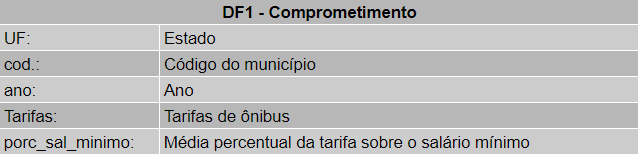

In [ ]:
df1.head()

,sigla_uf,id_municipio,ano,tarifas,comprometimento_salario_minimo,comprometimento_renda_domesticas_negras
0,SE,2800308,2005,1.45,0.250000,0.232894
1,PA,1501402,2005,1.15,0.266667,0.146684
2,MG,3106200,2005,1.65,0.283333,0.155192
3,RR,1400100,2005,1.80,0.300000,0.229592
4,DF,5300108,2005,1.60,0.258333,0.170321


In [ ]:
# Verificando tipos de dados
df1.dtypes

sigla_uf                                    object
id_municipio                                 int64
ano                                          int64
tarifas                                    float64
comprometimento_salario_minimo             float64
comprometimento_renda_domesticas_negras    float64
dtype: object

In [ ]:
# Renomeando colunas
df1.rename(columns={'sigla_uf':'UF',
                    'id_municipio':'cod',
                    'comprometimento_salario_minimo': 'porc_sal_minimo',
                    'comprometimento_renda_domesticas_negras':'porc_renda_negras'},inplace=True)

In [ ]:
df1.sample(2)

,UF,cod,ano,tarifas,porc_sal_minimo,porc_renda_negras
34,PR,4106902,2006,1.8,0.250000,0.169747
223,PR,4106902,2014,2.7,0.165746,0.172150


In [ ]:
# Verificação de dados nulos
df1.isna().sum()

UF                    0
cod                   0
ano                   0
tarifas               0
porc_sal_minimo       0
porc_renda_negras    81
dtype: int64

In [ ]:
# Filtro para a coluna porc_renda_negras
filtro_nulo = df1.porc_renda_negras.isna()
df1.loc[filtro_nulo].head()

,UF,cod,ano,tarifas,porc_sal_minimo,porc_renda_negras
270,RO,1100205,2010,2.30,0.191176,NaN
271,AC,1200401,2010,1.90,0.166667,NaN
272,AM,1302603,2010,2.25,0.225490,NaN
273,RR,1400100,2010,2.00,0.196078,NaN
274,PA,1501402,2010,1.70,0.196078,NaN


In [ ]:
# Agrupando coluna para checar quais dados faltam
df1.groupby('ano')['porc_renda_negras'].mean()

ano
2005    0.200014
2006    0.205551
2007    0.205044
2008    0.200164
2009    0.205706
2010         NaN
2011    0.206242
2012    0.204469
2013    0.201293
2014    0.198255
2015    0.215779
2016         NaN
2017         NaN
Name: porc_renda_negras, dtype: float64

In [ ]:
# Criando um DataFrame a partir de dados recentes de tarifas, coletados em fontes oficiais das prefeituras
novos_dados = {
    'UF': ['BA', 'BA', 'BA', 'BA', 'BA', 'CE', 'CE', 'CE', 'CE', 'CE', 'DF', 'DF', 'DF', 'DF', 'DF', 'MG', 'MG', 'MG', 'MG', 'MG', 'PA', 'PA', 'PA', 'PA', 'PA', 'PE', 'PE', 'PE', 'PE', 'PE', 'PR', 'PR', 'PR', 'PR', 'PR', 'RJ', 'RJ', 'RJ', 'RJ', 'RJ', 'SP', 'SP', 'SP', 'SP', 'SP'],
    'cod': [2927408, 2927408, 2927408, 2927408, 2927408, 2304400, 2304400, 2304400, 2304400, 2304400, 5300108, 5300108, 5300108, 5300108, 5300108, 3106200, 3106200, 3106200, 3106200, 3106200, 1501402, 1501402, 1501402, 1501402, 1501402, 2611606, 2611606, 2611606, 2611606, 2611606, 4106902, 4106902, 4106902, 4106902, 4106902, 3304557, 3304557, 3304557, 3304557, 3304557, 3550308, 3550308, 3550308, 3550308, 3550308],
    'ano': [2018, 2019, 2020, 2021, 2022, 2018, 2019, 2020, 2021, 2022, 2018, 2019, 2020, 2021, 2022, 2018, 2019, 2020, 2021, 2022, 2018, 2019, 2020, 2021, 2022, 2018, 2019, 2020, 2021, 2022, 2018, 2019, 2020, 2021, 2022, 2018, 2019, 2020, 2021, 2022, 2018, 2019, 2020, 2021, 2022],
    'tarifas': [3.7, 4.00, 4.2, 4.4, 4.9, 3.4, 3.6, 3.6, 3.6, 3.9, 3.5, 3.8, 3.8, 4.6, 5.5, 3.3, 3.5, 3.7, 4.00, 4.5, 3.30, 3.60, 3.60, 3.60, 4.00, 3.2, 3.45, 3.45, 3.75, 4.1, 4.3, 4.5, 4.5, 4.5, 5.5, 3.95, 4.05, 4.05, 4.05, 4.05, 4.00, 4.30, 4.40, 4.40, 4.40],
    'porc_sal_minimo': [0.155136268343816, 0.160320641282565, 0.160765550239234, 0.16, 0.161716171617162, 0.142557651991614, 0.144288577154309, 0.137799043062201, 0.130909090909091, 0.128712871287129, 0.146750524109015, 0.152304609218437, 0.145454545454545, 0.167272727272727, 0.181518151815182, 0.138364779874214, 0.140280561122244, 0.141626794258373, 0.145454545454545, 0.148514851485149, 0.138364779874214, 0.144288577154309, 0.137799043062201, 0.130909090909091, 0.132013201320132, 0.134171907756813, 0.138276553106212, 0.132057416267943, 0.136363636363636, 0.135313531353135, 0.180293501048218, 0.180360721442886, 0.172248803827751, 0.163636363636364, 0.181518151815182, 0.165618448637317, 0.162324649298597, 0.155023923444976, 0.147272727272727, 0.133663366336634, 0.167714884696017, 0.172344689378758, 0.168421052631579, 0.16, 0.145214521452145],
}

# Adicionando as novas linhas ao DataFrame existente
df_novo = pd.DataFrame(novos_dados)
df1 = pd.concat([df1, df_novo], ignore_index=True)

print(df1)

     UF      cod   ano  tarifas  porc_sal_minimo  porc_renda_negras
0    SE  2800308  2005     1.45         0.250000           0.232894
1    PA  1501402  2005     1.15         0.266667           0.146684
2    MG  3106200  2005     1.65         0.283333           0.155192
3    RR  1400100  2005     1.80         0.300000           0.229592
4    DF  5300108  2005     1.60         0.258333           0.170321
..   ..      ...   ...      ...              ...                ...
391  SP  3550308  2018     4.00         0.167715                NaN
392  SP  3550308  2019     4.30         0.172345                NaN
393  SP  3550308  2020     4.40         0.168421                NaN
394  SP  3550308  2021     4.40         0.160000                NaN
395  SP  3550308  2022     4.40         0.145215                NaN

[396 rows x 6 columns]


In [ ]:
df1back2=df1.copy()

In [ ]:
# Filtro por UF e ano das capitais existentes nas outras tabelas
df1=df1back2
filtro_uf = df1['UF'].isin(['BA', 'CE', 'DF', 'MG', 'PA', 'PE', 'PR', 'RJ', 'SP'])
filtro_ano = df1.ano>2017

df1 = df1.loc[filtro_uf & filtro_ano]

In [ ]:
df1.count()

UF                   45
cod                  45
ano                  45
tarifas              45
porc_sal_minimo      45
porc_renda_negras     0
dtype: int64

In [ ]:
# Exclusão de coluna que não será trabalhada
df1.drop(['porc_renda_negras'],axis=1, inplace=True)

In [ ]:
# Arredondamento dos valores
df1.sample(6).round(2)

,UF,cod,ano,tarifas,porc_sal_minimo
364,DF,5300108,2021,4.60,0.17
374,PA,1501402,2021,3.60,0.13
377,PE,2611606,2019,3.45,0.14
363,DF,5300108,2020,3.80,0.15
370,MG,3106200,2022,4.50,0.15
392,SP,3550308,2019,4.30,0.17


###DF2 - Deslocamentos

Dicionário

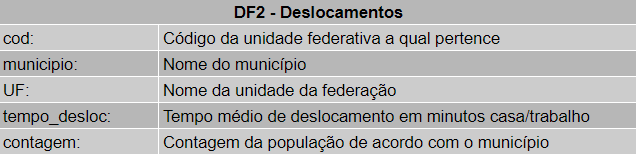

In [ ]:
df2.head(6)

,Indice_busca,Cod,Município,Estado,Tempo habitual de deslocamento para o trabalho,Unnamed: 5,Tempo médio,% acima de 1 hora,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,5200050 - Até cinco minutos,5200050,Abadia de Goiás,GO,Até cinco minutos,482,-,-,NaN,NaN,NaN,NaN,NaN
1,5200050 - De seis minutos até meia hora,5200050,Abadia de Goiás,GO,De seis minutos até meia hora,942,-,-,NaN,NaN,NaN,NaN,NaN
2,5200050 - Mais de duas horas,5200050,Abadia de Goiás,GO,Mais de duas horas,46,-,-,NaN,NaN,NaN,NaN,NaN
3,5200050 - Mais de meia hora até uma hora,5200050,Abadia de Goiás,GO,Mais de meia hora até uma hora,726,-,-,NaN,NaN,NaN,NaN,NaN
4,5200050 - Mais de uma hora até duas horas,5200050,Abadia de Goiás,GO,Mais de uma hora até duas horas,420,-,-,NaN,NaN,NaN,NaN,NaN
5,5200050 - Total,5200050,Abadia de Goiás,GO,Total,2615,36,0.178203,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Visualização de tipos
df2.dtypes

Indice_busca                                       object
Cod                                                 int64
Município                                          object
Estado                                             object
Tempo habitual de deslocamento para o trabalho     object
Unnamed: 5                                          int64
Tempo médio                                        object
% acima de 1 hora                                  object
Unnamed: 8                                        float64
Unnamed: 9                                        float64
Unnamed: 10                                       float64
Unnamed: 11                                       float64
Unnamed: 12                                       float64
dtype: object

In [ ]:
# Contagem dos dados
df2.count()

Indice_busca                                      33370
Cod                                               33390
Município                                         33390
Estado                                            33390
Tempo habitual de deslocamento para o trabalho    33390
Unnamed: 5                                        33390
Tempo médio                                       33390
% acima de 1 hora                                 33390
Unnamed: 8                                            0
Unnamed: 9                                            0
Unnamed: 10                                           6
Unnamed: 11                                           6
Unnamed: 12                                           1
dtype: int64

In [ ]:
# Excluindo colunas com campos vazios e repetidos
df2.drop(['Indice_busca',
          'Tempo médio',
          '% acima de 1 hora',
          'Unnamed: 8',
          'Unnamed: 9',
          'Unnamed: 10',
          'Unnamed: 11',
          'Unnamed: 12'],axis=1, inplace=True)

In [ ]:
# Renomeando colunas
df2.rename(columns={'Tempo habitual de deslocamento para o trabalho':'tempo_desloc',
                    'Unnamed: 5':'contagem','Estado':'UF','Cod':'cod',
                    'Município':'municipio'},inplace=True)

In [ ]:
# Filtro para excluir a linha Total dos municípios
filtro = df2.tempo_desloc !='Total'
df2 = df2.loc[filtro]

In [ ]:
df2.head(6)

,cod,municipio,UF,tempo_desloc,contagem
0,5200050,Abadia de Goiás,GO,Até cinco minutos,482
1,5200050,Abadia de Goiás,GO,De seis minutos até meia hora,942
2,5200050,Abadia de Goiás,GO,Mais de duas horas,46
3,5200050,Abadia de Goiás,GO,Mais de meia hora até uma hora,726
4,5200050,Abadia de Goiás,GO,Mais de uma hora até duas horas,420
6,3100104,Abadia dos Dourados,MG,Até cinco minutos,436


In [ ]:
# Contagem dos dados
df2.count()

cod             27825
municipio       27825
UF              27825
tempo_desloc    27825
contagem        27825
dtype: int64

In [ ]:
# Visualização de dados nulos
df2.isna().sum()

cod             0
municipio       0
UF              0
tempo_desloc    0
contagem        0
dtype: int64

In [ ]:
# Verificar valores únicos
print(pd.unique(df2['UF']))

['GO' 'MG' 'PA' 'CE' 'BA' 'PR' 'SC' 'PE' 'TO' 'MA' 'RN' 'PI' 'RS' 'MT'
 'AC' 'SP' 'ES' 'PB' 'AL' 'MS' 'RO' 'RR' 'AM' 'AP' 'SE' 'RJ' 'DF']


In [ ]:
# Filtro por UF e municipio das capitais existentes nas outras tabelas
filtro_uf2 = df2['UF'].isin(['BA', 'CE', 'DF', 'MG', 'PA', 'PE', 'PR', 'RJ', 'SP'])
filtro_municipio2 = df2['municipio'].isin(['Salvador', 'Fortaleza', 'Brasília', 'Belo Horizonte', 'Belém', 'Recife', 'Curitiba', 'Rio de Janeiro', 'São Paulo'])
df2 = df2.loc[filtro_uf2 & filtro_municipio2 ]

In [ ]:
df2.sample(5)

,cod,municipio,UF,tempo_desloc,contagem
4525,5300108,Brasília,DF,De seis minutos até meia hora,405333
25970,2927408,Salvador,BA,Mais de duas horas,23239
3486,1201402,Belém,PA,Mais de uma hora até duas horas,40614
3546,3106200,Belo Horizonte,MG,Até cinco minutos,55330
3549,3106200,Belo Horizonte,MG,Mais de meia hora até uma hora,331673


###DF3 - População

Dicionário

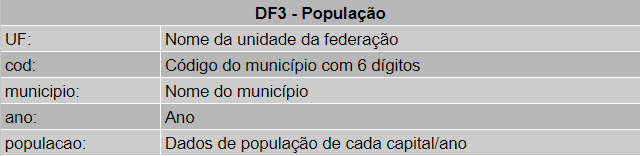

In [ ]:
df3.head(6)

,COD_UF,UF,CD_MUN6,CD_MUN7,MUNICIPIO,CAPITAL,REGIAO METROPOLITANA,Pop_2000,Pop_2001,Pop_2002,...,Pop_2013,Pop_2014,Pop_2015,Pop_2016,Pop_2017,Pop_2018,Pop_2019,Pop_2020,Pop_2021,Pop_2022
0,11,RO,1100205,110020,Porto Velho,Sim,Região Metropolitana de Porto Velho,334661,342264,347844,...,484992,494013,502748,511219,519436,519531,529544,539354,548952,460413
1,12,AC,1200401,120040,Rio Branco,Sim,-,253059,261430,267740,...,357194,363928,370550,377057,383443,401155,407319,413418,419452,364756
2,13,AM,1302603,130260,Manaus,Sim,Região Metropolitana de Manaus,1405835,1451958,1488805,...,1982177,2020301,2057711,2094391,2130264,2145444,2182763,2219580,2255903,2063547
3,14,RR,1400100,140010,Boa Vista,Sim,Região Metropolitana da Capital,200568,208514,214541,...,308996,314900,320714,326419,332020,375374,399213,419652,436591,413486
4,15,PA,1501402,150140,Belém,Sim,Região Metropolitana de Belém,1280614,1304314,1322683,...,1425922,1432844,1439561,1446042,1452275,1485732,1492745,1499641,1506420,1303389
5,16,AP,1600303,160030,Macapá,Sim,Região Metropolitana de Macapá,283308,295898,306583,...,437256,446757,456171,465495,474706,493634,503327,512902,522357,442933


In [ ]:
# Visualização de tipos
df3.dtypes

NameError: ignored

In [ ]:
# Contagem dos dados
df3.count()

COD_UF                  27
UF                      27
CD_MUN6                 27
CD_MUN7                 27
MUNICIPIO               27
CAPITAL                 27
REGIAO METROPOLITANA    27
Pop_2000                27
Pop_2001                27
Pop_2002                27
Pop_2003                27
Pop_2004                27
Pop_2005                27
Pop_2006                27
Pop_2007                27
Pop_2008                27
Pop_2009                27
Pop_2010                27
Pop_2011                27
Pop_2012                27
Pop_2013                27
Pop_2014                27
Pop_2015                27
Pop_2016                27
Pop_2017                27
Pop_2018                27
Pop_2019                27
Pop_2020                27
Pop_2021                27
Pop_2022                27
dtype: int64

In [ ]:
# Excluindo colunas que não serão trabalhadas na análise
df3.drop(['REGIAO METROPOLITANA','COD_UF', 'CD_MUN6', 'Pop_2000','CAPITAL',
                     'Pop_2001', 'Pop_2002', 'Pop_2003', 'Pop_2004', 'Pop_2005',
           'Pop_2006','Pop_2007','Pop_2008', 'Pop_2009','Pop_2010', 'Pop_2011', 'Pop_2012',
           'Pop_2013', 'Pop_2014', 'Pop_2015', 'Pop_2016'],axis=1, inplace=True)

In [ ]:
df3.head()

,UF,CD_MUN7,MUNICIPIO,Pop_2017,Pop_2018,Pop_2019,Pop_2020,Pop_2021,Pop_2022
0,RO,110020,Porto Velho,519436,519531,529544,539354,548952,460413
1,AC,120040,Rio Branco,383443,401155,407319,413418,419452,364756
2,AM,130260,Manaus,2130264,2145444,2182763,2219580,2255903,2063547
3,RR,140010,Boa Vista,332020,375374,399213,419652,436591,413486
4,PA,150140,Belém,1452275,1485732,1492745,1499641,1506420,1303389


In [ ]:
# Contagem dos dados
df3.count()

UF           27
CD_MUN7      27
MUNICIPIO    27
Pop_2017     27
Pop_2018     27
Pop_2019     27
Pop_2020     27
Pop_2021     27
Pop_2022     27
dtype: int64

In [ ]:
#verificar nulos
df3.isna().sum()

UF           0
CD_MUN7      0
MUNICIPIO    0
Pop_2017     0
Pop_2018     0
Pop_2019     0
Pop_2020     0
Pop_2021     0
Pop_2022     0
dtype: int64

In [ ]:
# Renomeando colunas
df3.rename(columns={'CD_MUN7':'cod',
                    'Pop_2017':'2017',
                    'Pop_2018':'2018',
                    'Pop_2019':'2019',
                    'Pop_2020':'2020',
                    'Pop_2021':'2021',
                    'Pop_2022':'2022',
                    'MUNICIPIO':'municipio'},inplace=True)

In [ ]:
# Transpor colunas dos anos
df3 = df3.melt(id_vars=['UF', 'cod', 'municipio'],
                         value_vars=['2017', '2018', '2019', '2020', '2021', '2022'],
                         var_name='ano',
                         value_name='populacao')

# Exibir o DataFrame transposto
print(df3)

     UF     cod     municipio   ano  populacao
0    RO  110020   Porto Velho  2017     519436
1    AC  120040    Rio Branco  2017     383443
2    AM  130260        Manaus  2017    2130264
3    RR  140010     Boa Vista  2017     332020
4    PA  150140         Belém  2017    1452275
..   ..     ...           ...   ...        ...
157  RS  431490  Porto Alegre  2022    1332570
158  MS  500270  Campo Grande  2022     897938
159  MT  510340        Cuiabá  2022     650912
160  GO  520870       Goiânia  2022    1437237
161  DF  530010      Brasília  2022    2817068

[162 rows x 5 columns]


In [ ]:
# Transformar a coluna ano que está como string em int
df3['ano']=df3['ano'].astype(int)

In [ ]:
# Filtro por UF e ano das capitais existentes nas outras tabelas
filtro_uf = df3['UF'].isin(['BA', 'CE', 'DF', 'MG', 'PA', 'PE', 'PR', 'RJ', 'SP'])
filtro_ano = df3.ano>2017
df3 = df3.loc[filtro_uf & filtro_ano]

In [ ]:
df3.sample(6)

,UF,cod,municipio,ano,populacao
66,PE,261160,Recife,2019,1645727
46,SP,355030,São Paulo,2018,12176866
39,PE,261160,Recife,2018,1637834
120,PE,261160,Recife,2021,1661017
31,PA,150140,Belém,2018,1485732
144,CE,230440,Fortaleza,2022,2428678


###DF4 - Proximidade transportes






Dicionário

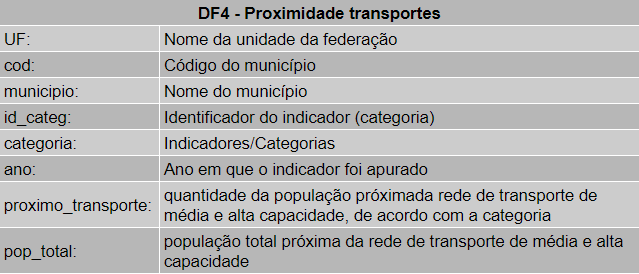

In [ ]:
df4.tail()

,UF,Cod,MUNICIPIO,ID,Categoria,ANO,proximo_transporte,pop_total
310,SP,3550308,SÃO PAULO,3,Domicílios_1/2_1,2021,103165,827366
311,SP,3550308,SÃO PAULO,4,Domicílios_1_3,2021,232665,1278658
312,SP,3550308,SÃO PAULO,5,Domicílios_3_mais,2021,284446,800482
313,SP,3550308,SÃO PAULO,6,Mulheres_negras,2021,260727,2134498
314,SP,3550308,SÃO PAULO,7,Mulheres_menos_1_salário_mínimo,2021,433974,2921008


In [ ]:
# Visualizar valores únicos de Categoria
print(pd.unique(df4['Categoria']))

['População' 'Domicílios_0_1/2' 'Domicílios_1/2_1' 'Domicílios_1_3'
 'Domicílios_3_mais' 'Mulheres_negras' 'Mulheres_menos_1_salário_mínimo']


In [ ]:
print(pd.unique(df4['ANO']))

[2017 2018 2019 2020 2021]


In [ ]:
# Verificar tipos de dados
df4.dtypes

UF                    object
Cod                    int64
MUNICIPIO             object
ID                     int64
Categoria             object
ANO                    int64
proximo_transporte     int64
pop_total              int64
dtype: object

In [ ]:
# Renomeando colunas
df4.rename(columns={'Categoria':'categoria',
                    'MUNICIPIO':'municipio',
                    'ID':'id_categ',
                    'Cod':'cod',
                    'ANO':'ano'},inplace=True)

In [ ]:
df4.sample(6)

,UF,cod,municipio,id_categ,categoria,ano,proximo_transporte,pop_total
162,PE,2611606,RECIFE,2,Domicílios_0_1/2,2019,25584,163773
94,CE,2304400,FORTALEZA,4,Domicílios_1_3,2018,23374,167849
63,PA,1501402,BELÉM,1,População,2018,110166,1391636
307,BA,2927408,SALVADOR,7,Mulheres_menos_1_salário_mínimo,2021,51511,920846
90,PR,4106902,CURITIBA,7,Mulheres_menos_1_salário_mínimo,2018,119542,403735
273,PR,4106902,CURITIBA,1,População,2021,564672,1744129


In [ ]:
# Filtro por UF e ano das capitais existentes nas outras tabelas
filtro_uf = df4['UF'].isin(['BA', 'CE', 'DF', 'MG', 'PA', 'PE', 'PR', 'RJ', 'SP'])
filtro_ano = df4.ano>2017
df4 = df4.loc[filtro_uf & filtro_ano]

In [ ]:
df4.sample(6)

,UF,cod,municipio,id_categ,categoria,ano,proximo_transporte,pop_total
64,PA,1501402,BELÉM,2,Domicílios_0_1/2,2018,7177,129521
243,BA,2927408,SALVADOR,6,Mulheres_negras,2020,61601,1123881
296,RJ,3304557,RIO DE JANEIRO,3,Domicílios_1/2_1,2021,147469,507158
290,PE,2611606,RECIFE,4,Domicílios_1_3,2021,22821,107145
255,PA,1501402,BELÉM,4,Domicílios_1_3,2021,17716,90673
248,SP,3550308,SÃO PAULO,4,Domicílios_1_3,2020,232229,1278658


###DF5- Motorização

Dicionário

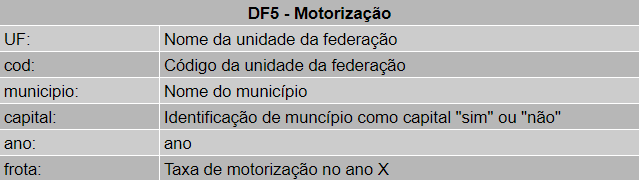

In [ ]:
# Visualização das primeiras linhas da tabela
df5.head()

,UF,Cod,MUNICIPIO,CAPITAL,ANO,FROTA
0,AC,120001,Acrelândia,Não,2017,4856
1,AC,120005,Assis Brasil,Não,2017,1485
2,AC,120010,Brasiléia,Não,2017,7638
3,AC,120013,Bujari,Não,2017,1652
4,AC,120017,Capixaba,Não,2017,1748


In [ ]:
# Verificar tipos de dados
df5.dtypes

UF           object
Cod           int64
MUNICIPIO    object
CAPITAL      object
ANO           int64
FROTA         int64
dtype: object

In [ ]:
# Contagem de dados
df5.count()

UF           33420
Cod          33420
MUNICIPIO    33420
CAPITAL      33420
ANO          33420
FROTA        33420
dtype: int64

In [ ]:
# Renomeando colunas
df5.rename(columns={'Cod':'cod',
                    'CAPITAL':'capital',
                    'MUNICIPIO':'municipio',
                    'ANO':'ano',
                    'FROTA':'frota'},inplace=True)

In [ ]:
# Filtro por UF, ano e capital dos dados existentes nas outras tabelas
filtro_uf = df5['UF'].isin(['BA', 'CE', 'DF', 'MG', 'PA', 'PE', 'PR', 'RJ', 'SP'])
filtro_ano = df5.ano>2017
filtro_capital = df5.capital == 'Sim'
df5 = df5.loc[filtro_uf & filtro_ano & filtro_capital ]

In [ ]:
df5.head()

,UF,cod,municipio,capital,ano,frota
6107,BA,292740,Salvador,Sim,2018,867786
6247,CE,230440,Fortaleza,Sim,2018,1033076
6373,DF,530010,Brasília,Sim,2018,1735359
6980,MG,310620,Belo Horizonte,Sim,2018,1994155
8006,PA,150140,Belém,Sim,2018,424369


### Backups

In [ ]:
df1back_tratado = df1.copy()
df2back_tratado = df2.copy()
df3back_tratado = df3.copy()
df4back_tratado = df4.copy()
df5back_tratado = df5.copy()

# **Carregamento**

### Carregamento GCP



In [ ]:
# GCP - Salvar no bucket
df1.to_csv('gs://insighttrafic/dados_tratados /comprometimento_tratado.csv', index=False)
df2.to_csv('gs://insighttrafic/dados_tratados /deslocamento_tratado.csv', index=False)
df3.to_csv('gs://insighttrafic/dados_tratados /populacao_capitais_tratado.csv', index=False)
df4.to_csv('gs://insighttrafic/dados_tratados /proximidade_transporte_tratado.csv', index=False)
df5.to_csv('gs://insighttrafic/dados_tratados /motorizacao_tratado.csv', index=False)

### MongoDB - dados tratados

#### Mongo DB - DF1

In [ ]:
# Escolhendo a base de dados e coleção
db1 = client['pf_tratados']
collection = db1['comprometimento']

In [ ]:
# Conversão para colocar no MongoDB
df1_dict = df1.to_dict("records")
collection.insert_many(df1_dict)

#### Mongo DB - DF2

In [ ]:
# Escolhendo a base de dados e coleção
db2 = client['pf_tratados']
collection = db2['deslocamentos']

In [ ]:
# Conversão para colocar no MongoDB
df2_dict = df2.to_dict("records")
collection.insert_many(df2_dict)

#### Mongo DB - DF3

In [ ]:
# Escolhendo a base de dados e coleção
db3 = client['pf_tratados']
collection = db3['populacao']

In [ ]:
# Conversão para colocar no MongoDB
df3_dict = df3.to_dict("records")
collection.insert_many(df3_dict)

#### Mongo DB - DF4

In [ ]:
# Escolhendo a base de dados e coleção
db4 = client['pf_tratados']
collection = db4['proximidade']

In [ ]:
# Conversão para colocar no MongoDB
df4_dict = df4.to_dict("records")
collection.insert_many(df4_dict)

#### Mongo DB - DF5

In [ ]:
# Escolhendo a base de dados e coleção
db5 = client['pf_motorizacao']
collection = db5['tratado']

In [ ]:
# Conversão para colocar no MongoDB
df5_dict = df5.to_dict("records")
collection.insert_many(df5_dict)

# **Análise exploratória de dados**

- Descrição de dados: identificação dos tipos de variáveis, dimensões dos dados, valores extremos e estatísticas descritivas.
- Visualização dos dados: criação de gráficos, tabelas e outros tipos de visualização para entender a distribuição e a relação entre as variáveis.
- Identificação de padrões: identificação de padrões, tendências, correlações e outras relações entre as variáveis.
- Testes estatísticos: aplicação de testes estatísticos para confirmar ou refutar hipóteses sobre os dados.

### **Instalações**

In [ ]:
!pip install geopandas

In [ ]:
import geopandas as gpd
import matplotlib.ticker as mticker

## **Análise Descritiva**
- Estatísticas descritivas do conjunto de dados;
- Distribuição das variáveis numéricas e categóricas;
- Identificação de outliers e tratamento, se necessário

In [ ]:
fcomprometimento=df1
fdesloc=df2
fpop=df3
fproximidade=df4
frota=df5

In [ ]:
# Análise estatística do dataframe comprometimento
fcomprometimento[['tarifas', 'porc_sal_minimo']].describe().round(2)

,tarifas,porc_sal_minimo
count,45.00,45.00
mean,4.01,0.15
std,0.52,0.02
min,3.20,0.13
25%,3.60,0.14
50%,4.00,0.15
75%,4.40,0.16
max,5.50,0.18


In [ ]:
# Análise estatística do dataframe deslocamento
fdesloc[['contagem']].describe().round(2)

,contagem
count,45.00
mean,244638.73
std,296337.87
min,4423.00
25%,49552.00
50%,151686.00
75%,331673.00
max,1346375.00


In [ ]:
# Análise estatística do dataframe população
fpop[['populacao']].describe().round()

,populacao
count,45.0
mean,3845768.0
std,3304435.0
min,1303389.0
25%,1917185.0
50%,2643247.0
75%,3055149.0
max,12396372.0


In [ ]:
# Análise estatística do dataframe proximidade
df4[['proximo_transporte', 'pop_total']].describe().round()

,proximo_transporte,pop_total
count,252.0,252.0
mean,172774.0,949058.0
std,358152.0,1653433.0
min,5580.0,45205.0
25%,21562.0,167849.0
50%,64372.0,464595.0
75%,167342.0,920846.0
max,2174338.0,11209673.0


In [ ]:
# Verificando percentual de pessoas próximas ao transporte
media_prox = df4['proximo_transporte'].mean()
media_pop = df4['pop_total'].mean()
perc_medio = (media_prox / media_pop) * 100
print(f'{perc_medio:.2f}%')

18.20%


In [ ]:
# Análise estatística do dataframe motorização
df5[['frota']].describe().round()

,frota
count,45.0
mean,2210345.0
std,2321442.0
min,424369.0
25%,896224.0
50%,1514051.0
75%,2290430.0
max,8757877.0


## **Análise de Grupos**
- Identificação de grupos no conjunto de dados;
- Visualização de gráficos de dispersão e boxplot para cada grupo

In [ ]:
fcomprometimento=df1
fdesloc=df2
fpop=df3
fproximidade=df4
frota=df5

In [ ]:
# Verificando tempo de deslocamento de cada grupo
fdesloc.groupby(['tempo_desloc'])['contagem'].sum().sort_values(ascending=False)

tempo_desloc
De seis minutos até meia hora      3930814
Mais de meia hora até uma hora     3917341
Mais de uma hora até duas horas    2109689
Até cinco minutos                   676239
Mais de duas horas                  374660
Name: contagem, dtype: int64

In [ ]:
# Verificando tempo de deslocamento de acordo com os estados
fdesloc.groupby(['UF'])['contagem'].sum().sort_values(ascending=False)

UF
SP    3806277
RJ    2064874
DF     985274
BA     904959
MG     887044
CE     791113
PR     657748
PE     487355
PA     424099
Name: contagem, dtype: int64

In [ ]:
# Verificando a proximidade da população ao transporte de cada grupo
fproximidade.groupby('categoria')['proximo_transporte'].sum().sort_values(ascending=False)

categoria
População                          24230824
Mulheres_menos_1_salário_mínimo     6051332
Mulheres_negras                     4727097
Domicílios_3_mais                   3013314
Domicílios_1_3                      2833362
Domicílios_1/2_1                    1496123
Domicílios_0_1/2                    1187122
Name: proximo_transporte, dtype: int64

## **Análise Geoespacial**

## Pyspark

In [ ]:
from pyspark.sql.functions import avg,round, col, year, when

In [ ]:
# Criando um dataframe em pyspark
df_py1 = spark.createDataFrame(df1)
df_py1.printSchema()
df_py1.show()

root
 |-- UF: string (nullable = true)
 |-- cod: long (nullable = true)
 |-- ano: long (nullable = true)
 |-- tarifas: double (nullable = true)
 |-- porc_sal_minimo: double (nullable = true)

+---+-------+----+-------+-----------------+
| UF|    cod| ano|tarifas|  porc_sal_minimo|
+---+-------+----+-------+-----------------+
| BA|2927408|2018|    3.7|0.155136268343816|
| BA|2927408|2019|    4.0|0.160320641282565|
| BA|2927408|2020|    4.2|0.160765550239234|
| BA|2927408|2021|    4.4|             0.16|
| BA|2927408|2022|    4.9|0.161716171617162|
| CE|2304400|2018|    3.4|0.142557651991614|
| CE|2304400|2019|    3.6|0.144288577154309|
| CE|2304400|2020|    3.6|0.137799043062201|
| CE|2304400|2021|    3.6|0.130909090909091|
| CE|2304400|2022|    3.9|0.128712871287129|
| DF|5300108|2018|    3.5|0.146750524109015|
| DF|5300108|2019|    3.8|0.152304609218437|
| DF|5300108|2020|    3.8|0.145454545454545|
| DF|5300108|2021|    4.6|0.167272727272727|
| DF|5300108|2022|    5.5|0.181518151815182

In [ ]:
# Calcular a média das tarifas por UF
media_tarifas_uf = df_py1.groupBy("UF").agg(round(avg("tarifas"),2).alias("media_tarifas_uf"))

# Exibir os resultados
media_tarifas_uf.show()

+---+----------------+
| UF|media_tarifas_uf|
+---+----------------+
| SP|             4.3|
| MG|             3.8|
| PA|            3.62|
| BA|            4.24|
| PE|            3.59|
| CE|            3.62|
| RJ|            4.03|
| DF|            4.24|
| PR|            4.66|
+---+----------------+



In [ ]:
# Calcular o comprometimento médio de salário mínimo por UF e ano
comprometimento_medio = df_py1.groupBy("UF", "ano").agg(round(avg("porc_sal_minimo"),2).alias("comprometimento_medio"))

# Exibir os resultados
comprometimento_medio.show()

+---+----+---------------------+
| UF| ano|comprometimento_medio|
+---+----+---------------------+
| DF|2020|                 0.15|
| PR|2022|                 0.18|
| BA|2019|                 0.16|
| CE|2021|                 0.13|
| MG|2021|                 0.15|
| PA|2022|                 0.13|
| PA|2020|                 0.14|
| PA|2018|                 0.14|
| PE|2018|                 0.13|
| PR|2019|                 0.18|
| RJ|2020|                 0.16|
| SP|2021|                 0.16|
| DF|2019|                 0.15|
| MG|2020|                 0.14|
| MG|2022|                 0.15|
| DF|2018|                 0.15|
| SP|2020|                 0.17|
| PR|2021|                 0.16|
| SP|2019|                 0.17|
| MG|2019|                 0.14|
+---+----+---------------------+
only showing top 20 rows



In [ ]:
# Criando um dataframe em pyspark
df_py4 = spark.createDataFrame(df4)
df_py4.printSchema()
df_py4.show()

root
 |-- UF: string (nullable = true)
 |-- cod: long (nullable = true)
 |-- municipio: string (nullable = true)
 |-- id_categ: long (nullable = true)
 |-- categoria: string (nullable = true)
 |-- ano: long (nullable = true)
 |-- proximo_transporte: long (nullable = true)
 |-- pop_total: long (nullable = true)

+---+-------+--------------+--------+--------------------+----+------------------+---------+
| UF|    cod|     municipio|id_categ|           categoria| ano|proximo_transporte|pop_total|
+---+-------+--------------+--------+--------------------+----+------------------+---------+
| PA|1501402|         BELÉM|       1|           População|2018|            110166|  1391636|
| PA|1501402|         BELÉM|       2|    Domicílios_0_1/2|2018|              7177|   129521|
| PA|1501402|         BELÉM|       3|    Domicílios_1/2_1|2018|              7692|   103778|
| PA|1501402|         BELÉM|       4|      Domicílios_1_3|2018|             10225|    90673|
| PA|1501402|         BELÉM|       5

In [ ]:
# Filtrar os dados para um ano específico
df_filtrado = df_py4.filter(col("ano") == 2021)

# Exibir os resultados
df_filtrado.show()

+---+-------+--------------+--------+--------------------+----+------------------+---------+
| UF|    cod|     municipio|id_categ|           categoria| ano|proximo_transporte|pop_total|
+---+-------+--------------+--------+--------------------+----+------------------+---------+
| PA|1501402|         BELÉM|       1|           População|2021|            194769|  1391636|
| PA|1501402|         BELÉM|       2|    Domicílios_0_1/2|2021|             13164|   129521|
| PA|1501402|         BELÉM|       3|    Domicílios_1/2_1|2021|             13282|   103778|
| PA|1501402|         BELÉM|       4|      Domicílios_1_3|2021|             17716|    90673|
| PA|1501402|         BELÉM|       5|   Domicílios_3_mais|2021|             10070|    45205|
| PA|1501402|         BELÉM|       6|     Mulheres_negras|2021|             69187|   519057|
| PA|1501402|         BELÉM|       7|Mulheres_menos_1_...|2021|             62132|   481080|
| MG|3106200|BELO HORIZONTE|       1|           População|2021|       

In [ ]:
# Calcular estatísticas descritivas
estatisticas_descritivas = df_py4.describe(["pop_total"])

# Exibir os resultados
estatisticas_descritivas.show()

+-------+-----------------+
|summary|        pop_total|
+-------+-----------------+
|  count|              252|
|   mean|949057.9365079365|
| stddev|1653433.212243674|
|    min|            45205|
|    max|         11209673|
+-------+-----------------+



# **Visualização**

## Gráficos DF1 - Comprometimento

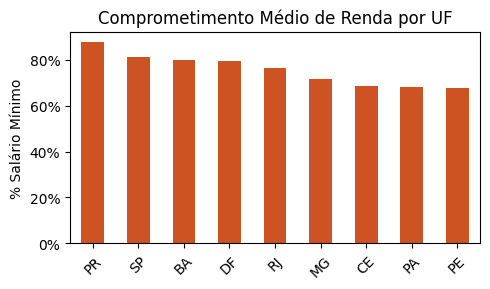

In [ ]:
# Comprometimento Médio de renda com tarifas por UF
comprom_medio = df1.groupby('UF')['porc_sal_minimo'].sum()

# Criando o gráfico de linha
comprom_medio.sort_values(ascending=False).plot.bar(figsize=(5, 3), color='#CD5322')

# Formatando os valores do eixo y em porcentagem
plt.gca().yaxis.set_major_formatter('{:.0%}'.format)

plt.title('Comprometimento Médio de Renda por UF')
plt.ylabel('% Salário Mínimo')
plt.xticks(rotation=45)
plt.xlabel('')
plt.tight_layout()
plt.show()

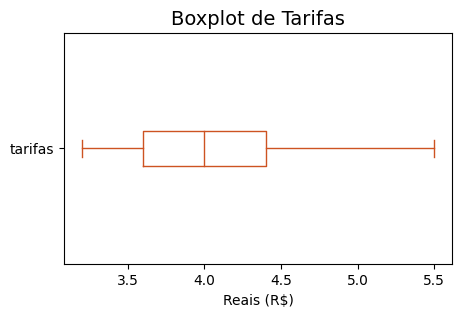

In [ ]:
# BoxPlot de tarifas
ax = df1.plot.box(column="tarifas", figsize=(5, 3), vert=False,color='#CD5322')
ax.set_title("Boxplot de Tarifas",fontsize=14)
ax.set_xlabel('Reais (R$)', fontsize=10)
plt.show()

## Gráficos DF2 - Tempo de Deslocamento

<Figure size 500x300 with 0 Axes>

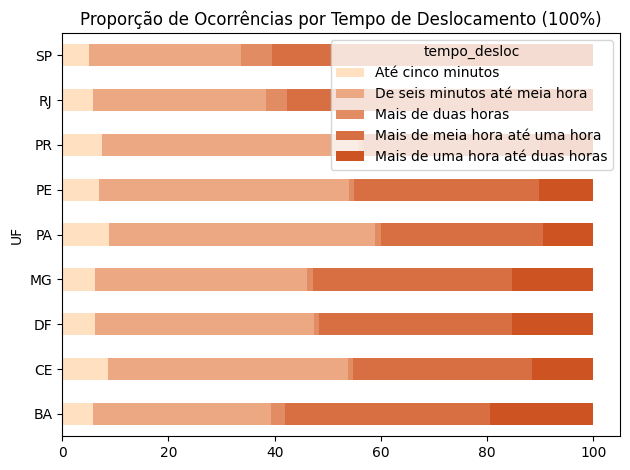

In [ ]:
df2_agrupado = df2.groupby(['UF', 'tempo_desloc'])['contagem'].sum().unstack()

# Proporção de cada categoria
percentual = grouped.div(grouped.sum(axis=1), axis=0) * 100

cores = ['#ffe1c2', '#eba882', '#e18c62', '#d76f42', '#CD5322']

# Criar o gráfico de barras horizontais empilhadas 100%
plt.figure(figsize=(5,3))
ax = percentual.plot(kind='barh', stacked=True, color=cores,legend=True)
plt.title('Proporção de Ocorrências por Tempo de Deslocamento (100%)')
plt.tight_layout()
plt.show()

## Gráficos DF3 - População

In [ ]:
# Acesso ao arquivo da GCP de geometria dos estados
client = storage.Client()
bucket = client.get_bucket('insighttrafic')
bucket.blob('estados_2010.shp')

# Carregar o arquivo de geometria dos estados brasileiros
shapefile_path = "gs://insighttrafic/estados_2010/estados_2010.shp"
gdf = gpd.read_file(shapefile_path)

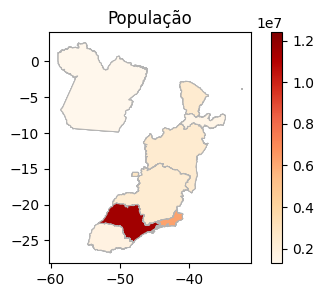

In [ ]:
# Mesclar o DataFrame de geometria com o seu DataFrame
merged = gdf.set_index('sigla').join(df3.set_index('UF'))

# Plotar o mapa
fig, ax = plt.subplots(1, 1, figsize=(5,3))
ax.set_title('População')

# Plotar o mapa com limites da escala de cores
merged.plot(column='populacao',cmap='OrRd', linewidth=0.7, ax=ax, edgecolor='0.7',legend=True)
plt.show()

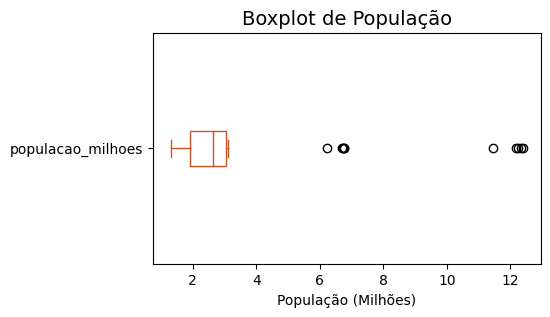

In [ ]:
# Convertendo os valores da coluna "populacao" para milhões
df3['populacao_milhoes'] = df3['populacao'] / 1000000

ax = df3.plot.box(column="populacao_milhoes", figsize=(5, 3), vert=False, color='#CD5322')
ax.set_title("Boxplot de População", fontsize=14)
ax.set_xlabel('População (Milhões)', fontsize=10)
ax.set_ylabel('')
plt.show()

## Gráficos DF4 - Proximidade de Transportes

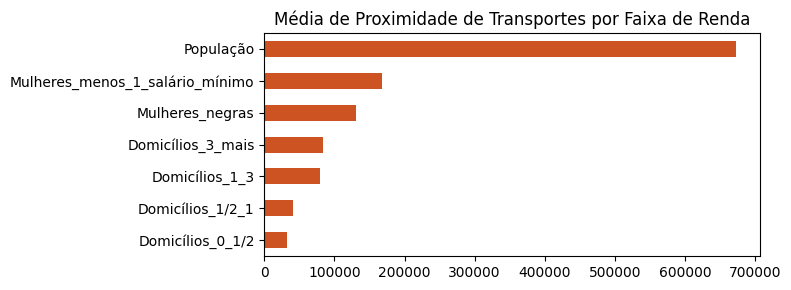

In [ ]:
# Proximidade de transporte por categoria de renda
prox_transp=df4.groupby('categoria')['proximo_transporte'].mean().sort_values(ascending=False)

# Gráfico de barras
prox_transp.sort_values(ascending=True).plot.barh(figsize=(8, 3), color='#CD5322')
plt.title('Média de Proximidade de Transportes por Faixa de Renda')
plt.ylabel('')
plt.tight_layout()
plt.show()

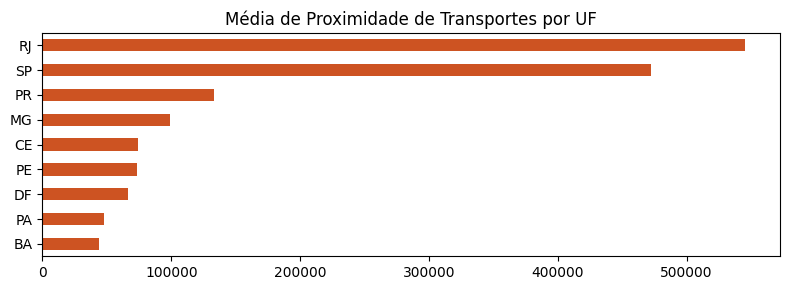

In [ ]:
# Proximidade de transporte por categoria de renda
prox_transp=df4.groupby('UF')['proximo_transporte'].mean().sort_values(ascending=False)

# Gráfico de barras
prox_transp.sort_values(ascending=True).plot.barh(figsize=(8, 3), color='#CD5322')
plt.title('Média de Proximidade de Transportes por UF')
plt.ylabel('')
plt.tight_layout()
plt.show()

## Gráficos DF5 - Taxa de Motorização

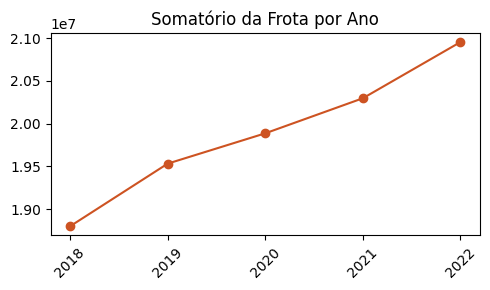

In [ ]:
# Calculando o somatório da frota por ano
soma_frota_ano = df5.groupby('ano')['frota'].sum()

# Criando o gráfico de linha
plt.figure(figsize=(5, 3))
plt.plot(soma_frota_ano.index, soma_frota_ano.values, marker='o', color='#CD5322')
plt.title('Somatório da Frota por Ano')
plt.ylabel('')
plt.xlabel('')
plt.xticks(soma_frota_ano.index, rotation=45)
plt.tight_layout()
plt.show()

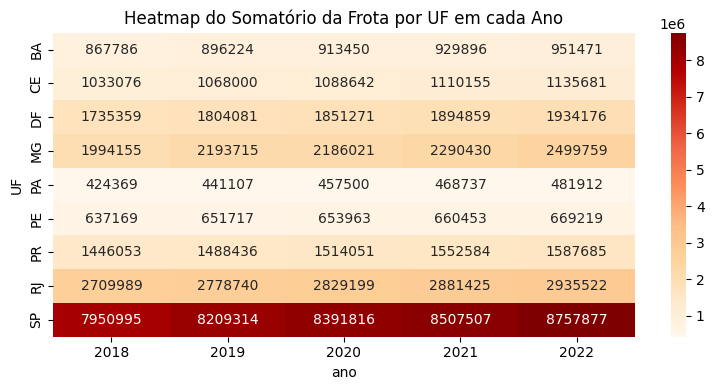

In [ ]:
# Gráfico Heatmap de Frota por UF e ano

pivot_df = df5.pivot_table(values='frota', index='UF', columns='ano', aggfunc=sum)
plt.figure(figsize=(8,4))
sns.heatmap(pivot_df, cmap='OrRd', annot=True, fmt='.0f')
plt.title('Heatmap do Somatório da Frota por UF em cada Ano')
plt.tight_layout()
plt.show()

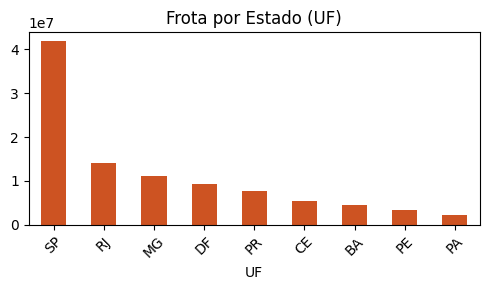

In [ ]:
# Agrupar frota por UF
frota_por_uf = df5.groupby('UF')['frota'].sum()

# Gráfico de barras
plt.figure(figsize=(5, 3))
frota_por_uf.sort_values(ascending=False).plot(kind='bar',color='#CD5322')
plt.title('Frota por Estado (UF)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## PYGWALKER

In [ ]:
!pip install pygwalker
import pygwalker as pyg
# intalando e importando o pygwalker

In [ ]:
gwalker = pyg.walk(df1)

# Conclusões da EDA (Análise Exploratória)

* Paraná, São Paulo e Bahia tem as maiores porcentagens de comprometimento do salário mínimo com tarifas de transporte.

* A tarifa de ônibus média é de 4 reais, sendo a mais cara de 5.50 reais no Distrito Federal.

* O gasto percentual médio é de 18.2%.

* Quanto maior a renda dos domicílios, mais próximos estão a rede de transportes de média e alta capacidade (metrô, trem, VLT, BRT).

* SP e RJ tem as maiores populações próximas a rede de transportes.

* A frota de veículos aumentou nos últimos anos, principalmente em São Paulo.